In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)


In [3]:
file_path = "transaction_dataset.csv"
df = pd.read_csv(file_path)


In [4]:
print("Dataset Shape:", df.shape)

Dataset Shape: (9841, 51)


In [5]:
print("Columns:", df.columns.tolist())

Columns: ['Unnamed: 0', 'Index', 'Address', 'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx'

In [6]:
print("First 5 rows:\n", df.head())

First 5 rows:
    Unnamed: 0  Index                                     Address  FLAG  \
0           0      1  0x00009277775ac7d0d59eaad8fee3d10ac6c805e8     0   
1           1      2  0x0002b44ddb1476db43c868bd494422ee4c136fed     0   
2           2      3  0x0002bda54cb772d040f779e88eb453cac0daa244     0   
3           3      4  0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e     0   
4           4      5  0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89     0   

   Avg min between sent tnx  Avg min between received tnx  \
0                    844.26                       1093.71   
1                  12709.07                       2958.44   
2                 246194.54                       2434.02   
3                  10219.60                      15785.09   
4                     36.61                      10707.77   

   Time Diff between first and last (Mins)  Sent tnx  Received Tnx  \
0                                704785.63       721            89   
1                               1

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                          9841

In [8]:
# 2. Data Cleaning and Preparation

df = df.drop(columns=['Unnamed: 0', 'Index', 'Address'])


In [9]:
# Check for missing values
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 FLAG                                                       0
Avg min between sent tnx                                   0
Avg min between received tnx                               0
Time Diff between first and last (Mins)                    0
Sent tnx                                                   0
Received Tnx                                               0
Number of Created Contracts                                0
Unique Received From Addresses                             0
Unique Sent To Addresses                                   0
min value received                                         0
max value received                                         0
avg val received                                           0
min val sent                                               0
max val sent                                               0
avg val sent                                               0
min value sent to contract                              

In [10]:
# 3. Define Features and Target
# ================================
# The target variable is 'FLAG' (assumed: 1 = fake, 0 = genuine)
y = df['FLAG']
X = df.drop(columns=['FLAG'])

In [11]:
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

In [12]:
print("\nNumerical Features:", numerical_cols)
print("Categorical Features:", categorical_cols)



Numerical Features: ['Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val rec', ' ERC2

In [13]:
# 4. Split Data into Training and Testing Sets
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [14]:
# ================================
# 5. Build Preprocessing Pipelines
# ================================
# Numerical pipeline: impute missing values with median and scale features.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [15]:
# Categorical pipeline: impute missing values with most frequent value and one-hot encode.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [16]:
# Combine both transformers using ColumnTransformer.
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])


In [17]:
# ================================
# 6. Build the Machine Learning Pipeline
# ================================
# The pipeline first preprocesses the data then trains a RandomForestClassifier.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [18]:
# 7. Hyperparameter Tuning using GridSearchCV
# ================================
# Define the hyperparameter grid for tuning the RandomForestClassifier.
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}


In [19]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)


In [20]:
# Train the model with hyperparameter tuning
print("\nStarting Grid Search for Hyperparameter Tuning...")
grid_search.fit(X_train, y_train)



Starting Grid Search for Hyperparameter Tuning...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Avg '
                                                                          'min '
                                                                          'between '
                                                                          'sent '
                                                                          'tnx',
                                                                          'Avg '
                                                                          'min '
                                                                          'between '
                                                                          'received '
                                                                          'tnx',
                                                                          'Time '
                                                                          'Diff '
                                                                          'between '
                                                                          'first '
                                                                          'and '
                                                                          'last '
                                                                          '(Mins)',
                                                                          'Sent '
                                                                          'tnx',
                                                                          'Received '
                                                                          'Tnx',
                                                                          'Number '
                                                                          'of '
                                                                          'Crea...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [' '
                                                                          'ERC20 '
                                                                          'most '
                                                                          'sent '
                                                                          'token '
                                                                          'type',
                                                                          ' '
                                                                          'ERC20_most_rec_token_type'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [21]:
print("\nBest Hyperparameters Found:")
print(grid_search.best_params_)
print("Best Cross-validation Accuracy: {:.4f}".format(grid_search.best_score_))


Best Hyperparameters Found:
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best Cross-validation Accuracy: 0.9896


In [22]:
# 8. Evaluate the Model

y_pred = grid_search.predict(X_test)

In [23]:
# Calculate accuracy and display classification report
test_accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy: {:.4f}".format(test_accuracy))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.9893

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1533
           1       1.00      0.95      0.98       436

    accuracy                           0.99      1969
   macro avg       0.99      0.98      0.98      1969
weighted avg       0.99      0.99      0.99      1969



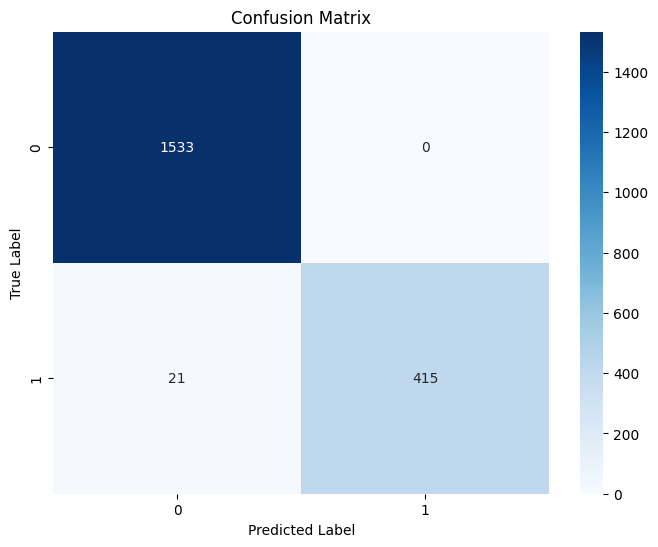

In [24]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [25]:
# ================================
# 9. Save the Trained Model
# ================================
model_filename = 'fake_identity_detector_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

print("\nModel successfully saved as '{}'".format(model_filename))




Model successfully saved as 'fake_identity_detector_model.pkl'


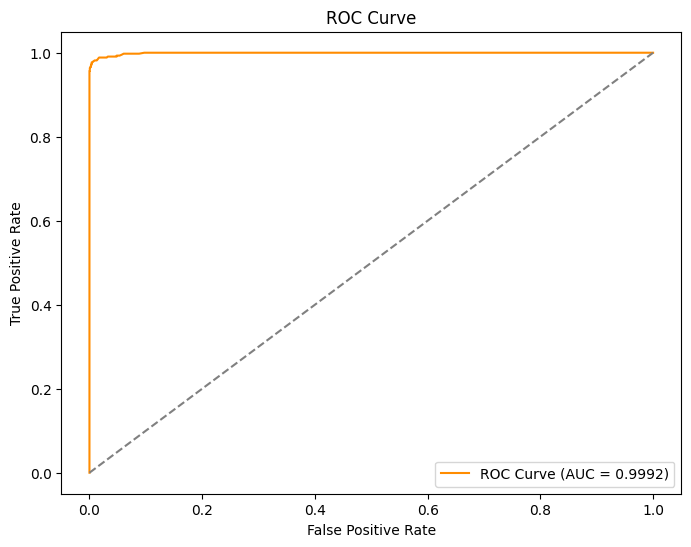

In [26]:
y_proba = grid_search.predict_proba(X_test)[:, 1]  # probability of class 1 (fraud)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


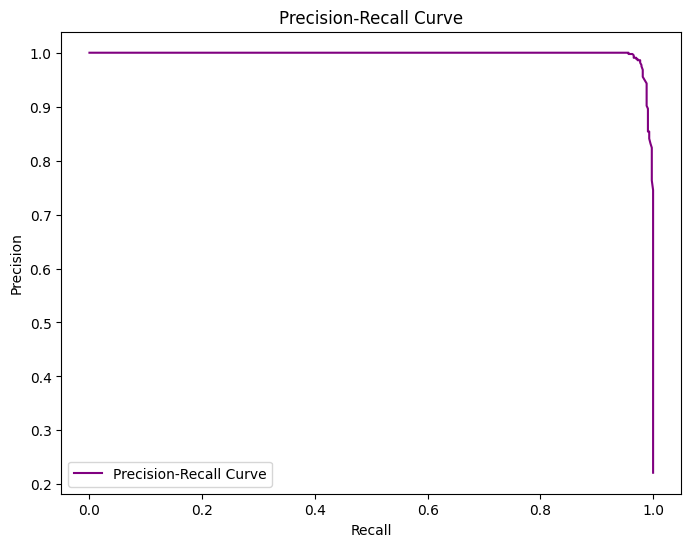

In [27]:
precisions, recalls, pr_thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Precision-Recall Curve", color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


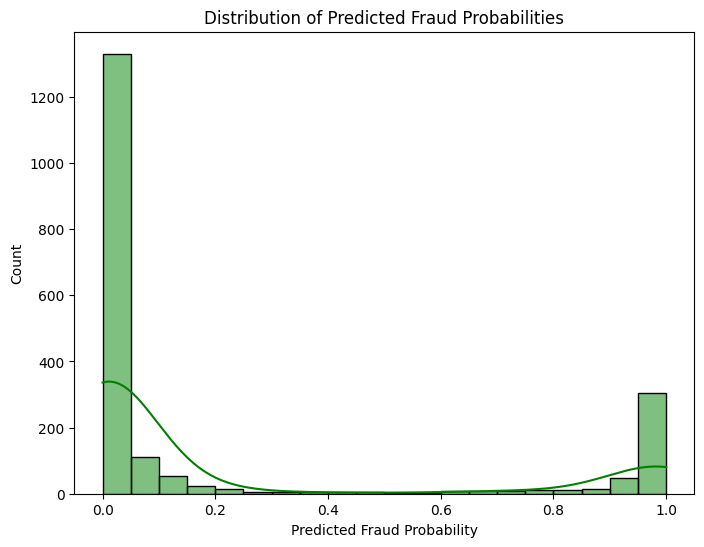

In [28]:
# 9.3 Predicted Probability Distribution
plt.figure(figsize=(8, 6))
sns.histplot(y_proba, bins=20, kde=True, color='green')
plt.xlabel("Predicted Fraud Probability")
plt.title("Distribution of Predicted Fraud Probabilities")
plt.show()


C:\Users\dhanu\AppData\Local\Temp\ipykernel_15796\1989233160.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='viridis')


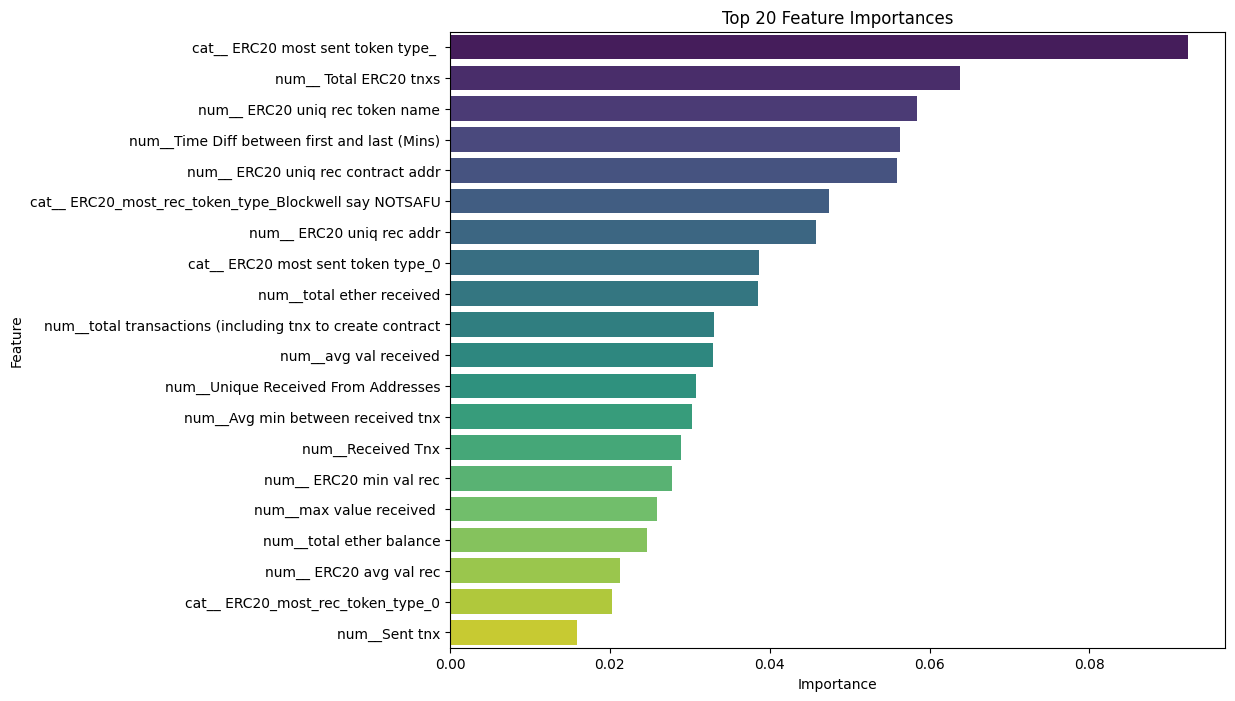

In [29]:
try:
    # Get feature names from preprocessor (requires scikit-learn 1.0+)
    feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
    importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
    feat_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='viridis')
    plt.title("Top 20 Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
except Exception as e:
    print("Feature importance extraction failed:", e)


In [30]:
# 10. Save the Trained Model
# ================================
model_filename = 'fake_identity_detector_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)
print("\nModel successfully saved as '{}'".format(model_filename))



Model successfully saved as 'fake_identity_detector_model.pkl'


In [31]:
# Load the saved model for simulation
with open(model_filename, 'rb') as f:
    model = pickle.load(f)

def simulate_transaction(input_data):
    """
    Simulate a single transaction:
    - input_data: dictionary of features (must match training features).
    Returns: prediction (0 or 1) and probability of fraud.
    """
    trans_df = pd.DataFrame([input_data])
    prediction = model.predict(trans_df)[0]
    proba = model.predict_proba(trans_df)[0, 1]  # probability for fraud (class 1)
    return prediction, proba


In [32]:
def generate_random_transaction():
    """
    Generate a random transaction input based on existing data (from X_test).
    """
    random_idx = random.randint(0, X_test.shape[0] - 1)
    sample = X_test.iloc[random_idx].to_dict()
    return sample


In [33]:
def real_time_monitoring(num_transactions=10, delay=1):
    """
    Simulate real-time monitoring of incoming transactions.
    For each transaction, predict fraud and simulate stopping the fraudulent transaction.
    """
    print("\n--- Starting Real-Time Transaction Monitoring Simulation ---")
    for i in range(num_transactions):
        trans = generate_random_transaction()
        prediction, proba = simulate_transaction(trans)
        print(f"\nTransaction {i+1}:")
        print(f"Predicted Fraud Probability: {proba:.4f}")
        if prediction == 1:
            print("⚠️ Fraudulent Transaction Detected! Stopping transaction.")
            # Insert real-world transaction halting logic here.
        else:
            print("Transaction appears genuine. Proceeding with processing.")
        time.sleep(delay)
    print("\n--- Simulation Completed ---")

In [34]:
# Run the real-time simulation (adjust number of transactions and delay as needed)
real_time_monitoring(num_transactions=10, delay=1)


--- Starting Real-Time Transaction Monitoring Simulation ---

Transaction 1:
Predicted Fraud Probability: 0.0700
Transaction appears genuine. Proceeding with processing.

Transaction 2:
Predicted Fraud Probability: 0.0250
Transaction appears genuine. Proceeding with processing.

Transaction 3:
Predicted Fraud Probability: 0.0250
Transaction appears genuine. Proceeding with processing.

Transaction 4:
Predicted Fraud Probability: 1.0000
⚠️ Fraudulent Transaction Detected! Stopping transaction.

Transaction 5:
Predicted Fraud Probability: 0.0050
Transaction appears genuine. Proceeding with processing.

Transaction 6:
Predicted Fraud Probability: 0.0900
Transaction appears genuine. Proceeding with processing.

Transaction 7:
Predicted Fraud Probability: 1.0000
⚠️ Fraudulent Transaction Detected! Stopping transaction.

Transaction 8:
Predicted Fraud Probability: 0.6150
⚠️ Fraudulent Transaction Detected! Stopping transaction.

Transaction 9:
Predicted Fraud Probability: 1.0000
⚠️ Fraudule

In [35]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Set a seed for reproducibility
random.seed(42)

# Define sample data generation functions
def generate_transaction_id(n):
    return [f"TX{str(i).zfill(6)}" for i in range(1, n+1)]

def generate_account_id(n):
    return [f"ACC{str(i).zfill(6)}" for i in range(1, n+1)]

def generate_block_hash(n):
    return [f"BLOCK{str(i).zfill(6)}" for i in range(1, n+1)]

def generate_ip_address():
    return '.'.join(str(random.randint(0, 255)) for _ in range(4))

def generate_device_info():
    return random.choice(["DeviceA", "DeviceB", "DeviceC", "DeviceD"])

def generate_geolocation():
    return random.choice(["US", "EU", "Asia", "Africa", "Oceania"])

def generate_transaction_type():
    return random.choice(["Regular Transfer", "Smart Contract Interaction"])

def generate_suspicious_flag():
    return random.choice([0, 1])

# Parameters
num_transactions = 1000
num_accounts = 500

# Generate synthetic transaction data
transaction_data = pd.DataFrame({
    'Transaction ID': generate_transaction_id(num_transactions),
    'Sender Address': random.choices(generate_account_id(num_accounts), k=num_transactions),
    'Receiver Address': random.choices(generate_account_id(num_accounts), k=num_transactions),
    'Amount Transferred': [round(random.uniform(0.01, 100), 2) for _ in range(num_transactions)],
    'Timestamp': [datetime.now() - timedelta(minutes=random.randint(1, 1440)) for _ in range(num_transactions)],
    'Transaction Type': [generate_transaction_type() for _ in range(num_transactions)],
    'Fraudulent Label': [generate_suspicious_flag() for _ in range(num_transactions)],
    'Suspicious Transaction Flags': [generate_suspicious_flag() for _ in range(num_transactions)],
    'Block Hash': generate_block_hash(num_transactions),
    'Block Number': [random.randint(100000, 999999) for _ in range(num_transactions)],
    'Mining Pool Information': random.choices(["PoolA", "PoolB", "PoolC", "PoolD"], k=num_transactions)
})

# Generate account data
account_data = pd.DataFrame({
    'Account ID': generate_account_id(num_accounts),
    'Account Creation Date': [datetime.now() - timedelta(days=random.randint(30, 365)) for _ in range(num_accounts)],
    'Account Activity Level': [random.choice(["Low", "Medium", "High"]) for _ in range(num_accounts)],
    'Account Age': [random.randint(1, 365) for _ in range(num_accounts)],
    'Account Balance': [round(random.uniform(0, 10000), 2) for _ in range(num_accounts)],
    'Account Reputation Score': [random.randint(0, 100) for _ in range(num_accounts)]
})

# Generate behavioral features
behavioral_data = pd.DataFrame({
    'Account ID': generate_account_id(num_accounts),
    'Transaction Volume': [round(random.uniform(100, 10000), 2) for _ in range(num_accounts)],
    'Transaction Frequency': [random.randint(1, 100) for _ in range(num_accounts)],
    'Number of Distinct Counterparties': [random.randint(1, 50) for _ in range(num_accounts)],
    'Time Between Transactions': [random.uniform(1, 24) for _ in range(num_accounts)],  # in hours
    'Number of Transactions per Day': [random.randint(1, 10) for _ in range(num_accounts)],
    'Pattern Consistency': random.choices([0, 1], k=num_accounts)  # 0: Inconsistent, 1: Consistent
})

# Generate Sybil-specific indicators
sybil_data = pd.DataFrame({
    'Account ID': generate_account_id(num_accounts),
    'Shared IP Address': [generate_ip_address() for _ in range(num_accounts)],
    'Device Information': [generate_device_info() for _ in range(num_accounts)],
    'Account Linking': random.choices([0, 1], k=num_accounts),  # 1: Linked, 0: Not Linked
    'Geographical Location': [generate_geolocation() for _ in range(num_accounts)],
    'Device Fingerprinting': [f"Fingerprint_{i}" for i in range(num_accounts)]
})

# Merge all dataframes to simulate the final dataset
final_dataset = transaction_data.merge(account_data, left_on='Sender Address', right_on='Account ID', how='left')
final_dataset = final_dataset.merge(behavioral_data, on='Account ID', how='left')
final_dataset = final_dataset.merge(sybil_data, on='Account ID', how='left')

# Drop the extra 'Account ID' column as it's no longer needed
final_dataset = final_dataset.drop(columns=['Account ID'])

# Display the first few rows of the final dataset
print(final_dataset.head())


  Transaction ID Sender Address Receiver Address  Amount Transferred  \
0       TX000001      ACC000320        ACC000050               14.33   
1       TX000002      ACC000013        ACC000343               66.02   
2       TX000003      ACC000138        ACC000273               22.11   
3       TX000004      ACC000112        ACC000489               30.06   
4       TX000005      ACC000369        ACC000180                6.11   

                   Timestamp            Transaction Type  Fraudulent Label  \
0 2025-02-27 00:59:40.024929  Smart Contract Interaction                 1   
1 2025-02-26 22:29:40.024929  Smart Contract Interaction                 0   
2 2025-02-26 21:15:40.024929            Regular Transfer                 0   
3 2025-02-27 13:01:40.024929            Regular Transfer                 1   
4 2025-02-27 15:09:40.024929            Regular Transfer                 0   

   Suspicious Transaction Flags   Block Hash  Block Number  ...  \
0                             1